In [1]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import os
from scipy import stats
from netCDF4 import Dataset
from regrid import regrid_fast
import datetime
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
# create regional anomalies smoothed
days = np.arange(0,208)
dates = [datetime.date(2018,10,5)+datetime.timedelta(days=np.int(days)) for days in days]

mask_values = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/NSIDC_Regions_Mask.npy')
regions = ['Baffin','Greenland','Barents','Kara','Laptev','E. Siberian','Chukchi','Beaufort','Central Arctic']
regs = [6,7,8,9,10,11,12,13,15]
wg_lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/auxiliary/lons.npy')
wg_lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/auxiliary/lats.npy')
ease_lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lon_25km.npy')
ease_lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/new_lat_25km.npy')

# function to calculate regional means 
def regions_WG(regs):
    WG_mean = []
    WG_c = all_interps.copy()
    for day in days:
        WG_c[day][~np.isin(mask_values, regs)] = np.nan
    for day in days:
        WG_mean.append(np.nanmean(WG_c[day]))
    return(WG_mean)

# function to calculate running mean, where T = np.int(number of days/2)
def runningmean(means,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(means[0:i+T]))

    for i in range(T,np.size(means)-T):
        r.append(np.nanmean(means[i-T:i+T]))

    for i in range(np.size(means)-T,np.size(means)):
        r.append(np.nanmean(means[i-T:]))

    return r

#import SM-LG datafile that contains 2010-2020 data
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])[3199:3407]

T = 15 # 31-day running mean

all_interps = snow
SM = {}
SM['Date']= dates
for region, reg in zip(regions, regs):
    dm = regions_WG(reg)
    rm = runningmean(dm,T=15)
    SM[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))
    
    
sats = ['CS2','CS2_3days','CS2_9days','CS2_15days']
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/MT_sensitivity/'
CS2 = {}; CS2_3days = {}; CS2_9days = {}; CS2_15days = {}
dfs = [CS2,CS2_3days,CS2_9days,CS2_15days]
pans = {}

for sat, df in zip (sats,dfs):
    location = datapath+sat+ '/'
    all_interps_wg = np.full((len(days),160,160),np.nan)
    for day in days:
        date = dates[day].strftime('%Y%m%d')
        for f in os.listdir(location):
            if 'FB_interp' in f:
                if date in f:
                    all_interps_wg[day] = np.load(location+str(f))
                else: 
                    pass
    all_interps = regrid_fast(all_interps_wg, wg_lons, wg_lats, ease_lons, ease_lats)
    pans[sat] = all_interps
    for region, reg in zip(regions, regs):
        dm = regions_WG(reg)
        rm = runningmean(dm,T=15)
        df[region] = np.asarray(runningmean(np.asarray(dm)-np.asarray(rm),T=4))    

In [3]:
## Pan-Arctic running means
T = 15 #31-day running mean
all_anoms = {}

SM_means = np.full((len(days)),np.nan)
for day in days:
    SM_means[day] = np.nanmean(snow[day])
rm = runningmean(SM_means,T=15) # SM-LG
all_anoms['SM'] = np.asarray(runningmean(np.asarray(SM_means)-np.asarray(rm),T=4))

for sat, df in zip(sats,pans):
    means = np.full((len(days)),np.nan)
    for day in days:
        means[day] = np.nanmean(pans[sat][day])
    rm = runningmean(means,T=15) 
    all_anoms[sat] = np.asarray(runningmean(np.asarray(means)-np.asarray(rm),T=4))

In [4]:
def stats():
    fb = df[region][day].squeeze()
    snow = SM[region][day].squeeze()
    mask = ~np.isnan(fb) & ~np.isnan(snow) 
    try:
        rstats = pearsonr(snow[mask],fb[mask])
        r = np.round(rstats[0],decimals=2)
        return(r)
    except:
        r = np.nan

In [5]:
days = [np.arange(0,27), # Oct
        np.arange(27,57), # Nov
        np.arange(57,88), # Dec
        np.arange(88,119), # Jan
        np.arange(119,147) # Feb
       ]

In [6]:
CS2_r = {}; CS2_3days_r = {}; CS2_9days_r = {}; CS2_15days_r = {}
rs = [CS2_r,CS2_3days_r,CS2_9days_r,CS2_15days_r]

for df,rf in zip(dfs,rs):
    for region in regions:
        monthly_stats = []
        for day in days:
            r = stats()
            monthly_stats.append(r)
        rf[region]=monthly_stats

In [7]:
panarctic = {}
for sat in sats:
    monthly_stats = []
    for day in days:
        fb = all_anoms[sat][day].squeeze()
        snow = all_anoms['SM'][day].squeeze()
        mask = ~np.isnan(fb) & ~np.isnan(snow) 
        try:
            rstats = pearsonr(snow[mask],fb[mask])
            r = np.round(rstats[0],decimals=2)
        except:
            r = np.nan
        monthly_stats.append(r)
    panarctic[sat]=monthly_stats

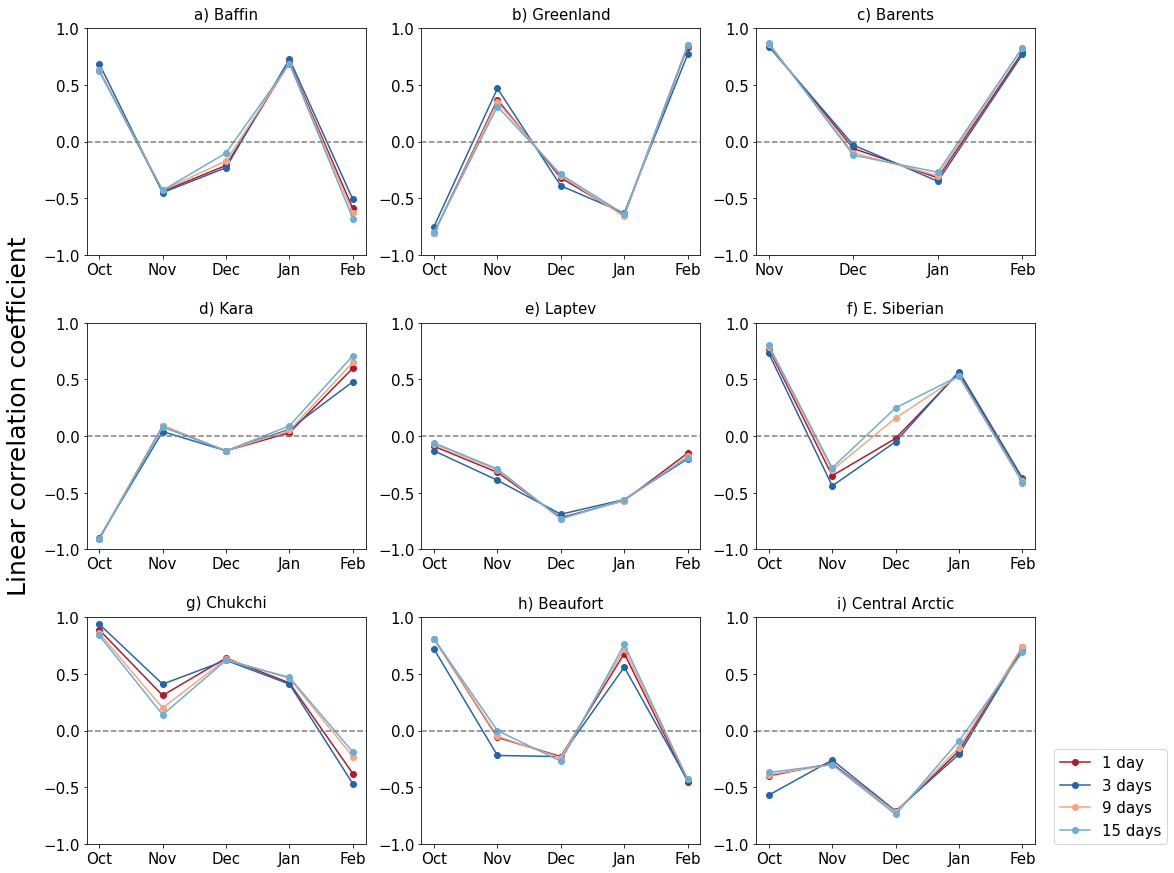

In [11]:
fig = plt.figure(figsize=(17,15))
spec = gridspec.GridSpec(ncols=3, nrows=3, wspace=0.2,hspace=0.3)
names = ['1 day','3 days','9 days','15 days']

colors = ['#b2182b','#2166ac','#f4a582','#6baed6']
months = ['Oct','Nov','Dec','Jan','Feb']
nums = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ', 'g) ', 'h) ', 'i) ', 'j) ', 'k)']

for count in np.arange(0,9):
    region = regions[count]
    ax = fig.add_subplot(spec[count])
    ax.set_title(nums[count]+region,pad=10,fontsize=15)
    for dic,sat,color,name in zip(rs,sats,colors,names):
        ax.plot(months,dic[region],label = name, color=color,marker="o")
    ax.axhline(0,linestyle='dashed',color='grey')
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-0.5,0,0.5,1])
    plt.rc('font', size=15)
    
    if count ==8:      
        ax.legend(bbox_to_anchor = (1.5, 0.45),fontsize=15)
fig.text(0.07, 0.36, 'Linear correlation coefficient', ha='center',fontsize=25,rotation='vertical')
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/supp_figs/MT_sensitivity.png',bbox_inches = "tight")